In [1]:
import numpy as np
import scipy as sp
import scipy.interpolate
import scipy.signal
import skimage as ski
import skimage.color, skimage.filters

import matplotlib.pyplot as plt

from itertools import pairwise

import cv2

#from ImageRectifier import RidgeExtractor, smooth_univariatespline, smooth_pwlf, RowRectifierPwlf
from ImageRectifier import RidgeExtractor, RowRectifier

# Load an image and rectify

In [2]:
# Load image
I = plt.imread('Rows.png')

# Rectify
rr = RowRectifier(smoothing_method='univar_spl', s=None, n_poly_sides=3)
rr.fit(I)
Iout, Isrc_polys, Isrc_ridges, Idst_polys, Idst_ridges = rr.transform(I, return_intermediates=True)

Result:

Text(0.5, 1.0, 'Rectified image')

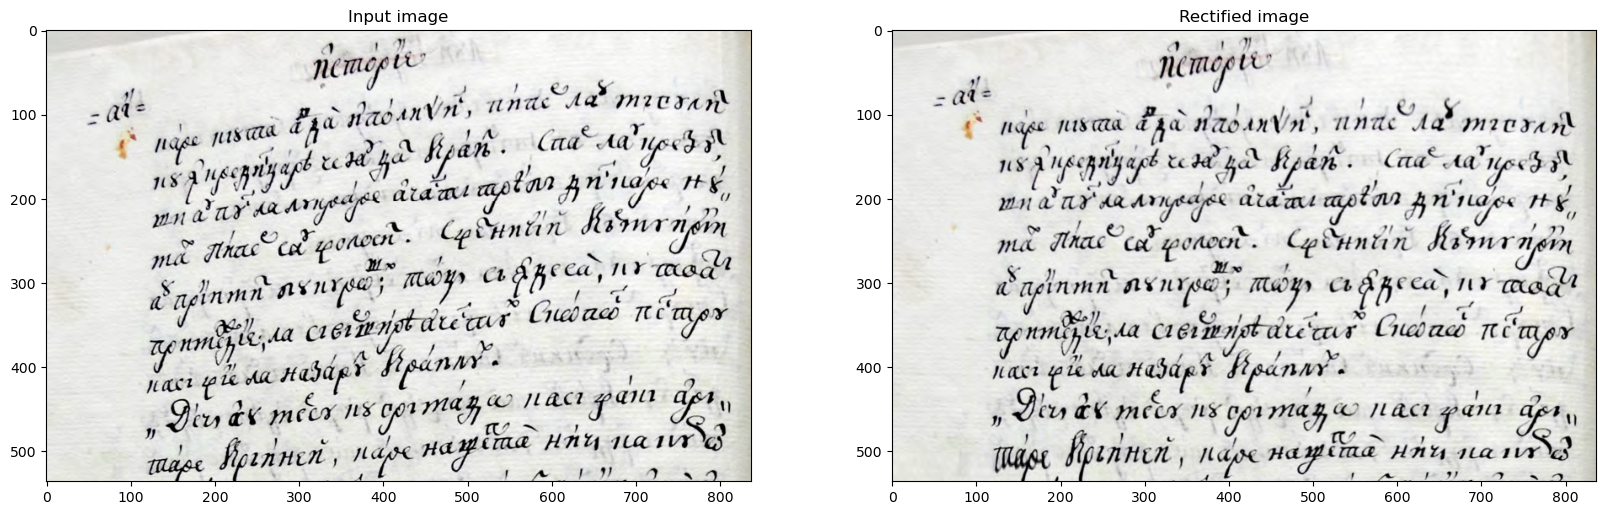

In [8]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(I)
plt.title("Input image")
plt.subplot(1, 2, 2)
plt.imshow(Iout)
plt.title("Rectified image")

# Detailed analysis

Text(0.5, 1.0, '4. Rectified result')

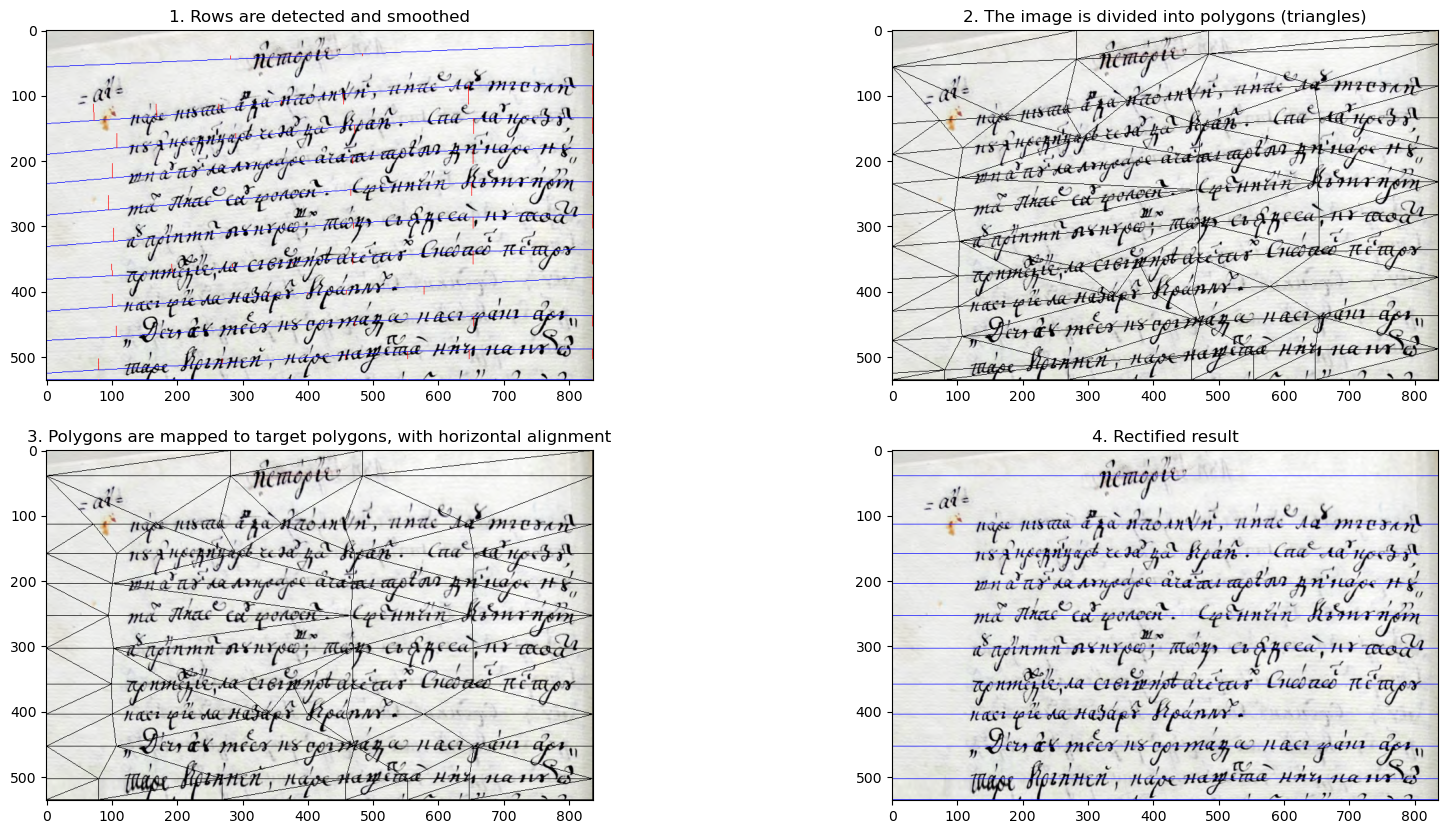

In [7]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.imshow(Isrc_ridges/255)
plt.title("1. Rows are detected and smoothed")
plt.subplot(2, 2, 2)
plt.imshow(Isrc_polys/255)
plt.title("2. The image is divided into polygons (triangles)")
plt.subplot(2, 2, 3)
plt.imshow(Idst_polys/255)
plt.title("3. Polygons are mapped to target polygons, with horizontal alignment")
plt.subplot(2, 2, 4)
plt.imshow(Idst_ridges/255)
plt.title("4. Rectified result")
